In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import os
from sklearn.model_selection import train_test_split

import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt

# 1. Load the Data

In [3]:
path = '/workspaces/aps360-winter2023/converted-data'

In [40]:
# Resize images to 288 x 288
transform = transforms.Compose([transforms.Resize((288, 288)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                transforms.ToTensor()])

# Normalize the data later!!

# TRANSFORMING THE DATA
data = torchvision.datasets.ImageFolder(path, transform=transform)

In [41]:
n = len(data)
n_valtest = int(0.2 * n)
valtest_data = torch.utils.data.Subset(data, range(n_valtest))
train_data = torch.utils.data.Subset(data, range(n_valtest, n))

In [42]:
n = len(valtest_data)
n_test = int(0.5 * n)
val_data = torch.utils.data.Subset(data, range(n_test))
test_data = torch.utils.data.Subset(data, range(n_test, n))

In [43]:
len(train_data)

15587

In [44]:
len(val_data)

1948

In [45]:
len(test_data)

1948

In [21]:
data_loader = torch.utils.data.DataLoader(data, batch_size=1, num_workers=1, shuffle=True)

In [31]:
print(data_loader)

In [4]:
# SPLIT THE DATA (80-10-10 split)
train_data, valtest_data = train_test_split(data, test_size=0.2)
val_data, test_data = train_test_split(valtest_data, test_size=0.5)

: 

: 

In [ ]:
# LOADING THE DATA
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1, shuffle=True)

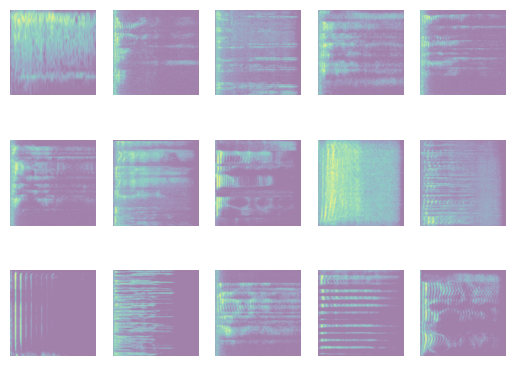

In [23]:
k = 0
for images, labels in data_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [ ]:
train_examples = len(train_loader)
validation_examples = len(val_loader)
test_examples = len(test_loader)

print("Number of training examples:", train_examples)
print("Number of validation examples:", validation_examples)
print("Number of testing examples:", test_examples)

# 2. Define the Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 5 x 5 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc2 = nn.Linear(50, 6) # 6 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # flatten to [batch_size]
        return x

In [ ]:
def get_accuracy(model, train_loader, val_loader, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        # select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=1, 
                                           shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                            num_workers=1, 
                                            shuffle=True)

    # training
    n = 0 # the number of iterations

    start_time = time.time()

    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss => CHANGED labels to to labels.float()
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        
        print("Epoch:", epoch + 1, "| Training Accuracy:", train_acc[epoch], "| Validation Accuracy:", val_acc[epoch])

        # checkpoints
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total Training Time:", round(end_time - start_time, 2), "seconds")

# 3. Sanity Check: Overfit to a Small Dataset

In [ ]:
model = CNN()
batch_size = 64
learning_rate = 0.01
num_epochs = 20
train(model, train_data, val_data, batch_size, learning_rate, num_epochs)

# 4. Hyperparameter Search

# 5. Test Data